In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

import itertools
from functools import partial

DATA_DIR = Path("/content/drive/My Drive/SH/data")

tf.keras.backend.clear_session()
tf.__version__

'2.1.0'

In [0]:
# Radial basis activation function: e^(-x^2)
@tf.function
def rbf(x):
    return tf.exp(-tf.pow(x, 2))

In [3]:
model = keras.models.Sequential([
    keras.layers.Dense(1,
                       use_bias=False,
                       input_shape=(2,),
                       activation=rbf)
])
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

<tf.Variable 'UnreadVariable' shape=(2, 1) dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [0]:
#model.compile(loss="mse", optimizer="sgd", metrics=["binary_accuracy"])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(momentum=.7), metrics=["accuracy"])

In [5]:
y = np.array([
    1,
    1,
    0,
    0
])
x = np.array([
    (0, 0),
    (2, 2),
    (2, 0),
    (0, 2)
])
x, y

(array([[0, 0],
        [2, 2],
        [2, 0],
        [0, 2]]), array([1, 1, 0, 0]))

In [6]:
def compute_subgoals(initial, goal, N, model, x):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return model.predict(x)

    subgoal_weights = tf.expand_dims(tf.linspace(0., 1, N), axis=-1) * (goal - initial) + initial

    subgoals = tf.stack([predict_for_weights(weights, x) for weights in subgoal_weights])
    subgoals = tf.squeeze(subgoals)
    
    return subgoal_weights, subgoals


initial = tf.constant([1., 1])
goal = tf.constant([1., -1])
N = 100 # number of subgoals

weights, subgoals = compute_subgoals(initial, goal, N, model, x)

subgoals

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[1.00000000e+00, 1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.00000000e+00, 1.55223461e-07, 1.83156393e-02, 2.14932542e-02],
       [1.00000000e+00, 2.13407034e-07, 1.83156393e-02, 2.51399297e-02],
       [1.00000000e+00, 2.92442934e-07, 1.83156393e-02, 2.93094944e-02],
       [1.00000000e+00, 3.99445071e-07, 1.83156393e-02, 3.40592042e-02],
       [1.00000000e+00, 5.43817976e-07, 1.83156393e-02, 3.94495912e-02],
       [1.00000000e+00, 7.37960704e-07, 1.83156393e-02, 4.55441773e-02],
       [1.00000000e+00, 9.98146561e-07, 1.83156393e-02, 5.24089150e-02],
       [1.00000000e+00, 1.34566608e-06, 1.83156393e-02, 6.01117499e-02],
       [1.00000000e+00, 1.80827033e-06, 1.83156393e-02, 6.87219948e-02],
       [1.00000000e+00, 2.42197711e-06, 1.83156393e-02, 7.83094391e-02],
       [1.00000000e+00, 3.23340305e-06, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 4.30260525e-06, 1.83156393e-02, 1.00692481e-01],
 

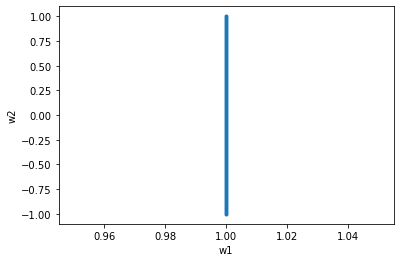

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

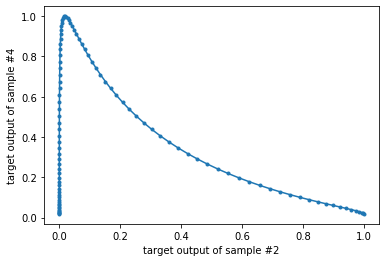

In [8]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 1], subgoals[..., 3], '.-')

In [11]:
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

training_weights = []
predictions = []

def train(model, subgoal, x, learning_rate = 0.01):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return tf.squeeze(model.predict(x))
    
    weight_changes = tf.constant([[-1., -1],
                                  [-1, 0],
                                  [-1, 1],
                                  [0, -1],
                                  #[0, 0],
                                  [0, 1],
                                  [1, -1],
                                  [1, 0],
                                  [1, 1]]) * learning_rate
    predict_fn = partial(predict_for_weights, x=x)

    initial_prediction = predict_fn(get_weights())
    training_weights.append(get_weights())
    predictions.append(initial_prediction)

    i = 0
    while True:
        curr_weights = get_weights()
        weight_tests = curr_weights + weight_changes
        prediction_tests = tf.map_fn(predict_fn, weight_tests)
        distances = tf.norm(prediction_tests - subgoal, axis=-1)
        best_index = tf.argmin(distances)
        set_weights(weight_tests[best_index])


        i+=1

        if tf.norm(prediction_tests[best_index] - subgoal) <= .5 * tf.norm(initial_prediction - subgoal):
            print(subgoal, prediction_tests[best_index])
            break
        

        training_weights.append(weight_tests[best_index])
        predictions.append(prediction_tests[best_index])

    
    return i

for i, subgoal in enumerate(subgoals[1:], 1):
    print(i, train(model, subgoal, x))

tf.Tensor([1.0000000e+00 1.5522346e-07 1.8315639e-02 2.1493254e-02], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 1.5472746e-07 1.8315639e-02 2.1459235e-02], shape=(4,), dtype=float32)
1 2
tf.Tensor([1.0000000e+00 2.1340703e-07 1.8315639e-02 2.5139930e-02], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 2.1205912e-07 1.8315639e-02 2.5062058e-02], shape=(4,), dtype=float32)
2 2
tf.Tensor([1.0000000e+00 2.9244293e-07 1.8315639e-02 2.9309494e-02], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 2.8970564e-07 1.8315639e-02 2.9176243e-02], shape=(4,), dtype=float32)
3 2
tf.Tensor([1.0000000e+00 3.9944507e-07 1.8315639e-02 3.4059204e-02], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 3.9451814e-07 1.8315639e-02 3.3857305e-02], shape=(4,), dtype=float32)
4 2
tf.Tensor([1.000000e+00 5.438180e-07 1.831564e-02 3.944959e-02], shape=(4,), dtype=float32) tf.Tensor([1.0000000e+00 5.3553396e-07 1.8315639e-02 3.9163865e-02], shape=(4,), dtype=float32)
5 2
tf.Tensor([1.0000000e+00

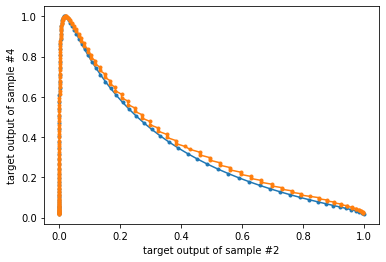

In [12]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 1], subgoals[..., 3], '.-')

# Plot our predictions
#predictions = np.array(logger.predictions).squeeze()
predictions=np.array(predictions)
ax.plot(predictions[..., 1], predictions[..., 3], '.-')

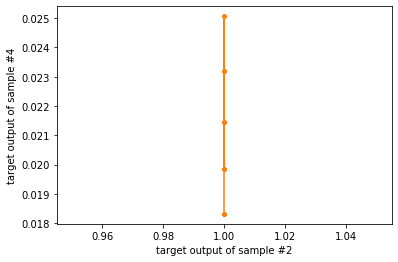

In [13]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #2")
ax.set_ylabel("target output of sample #4")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

# Plot our predictions
#predictions = np.array(logger.predictions).squeeze()
ax.plot(predictions[..., 0], predictions[..., 2], '.-')

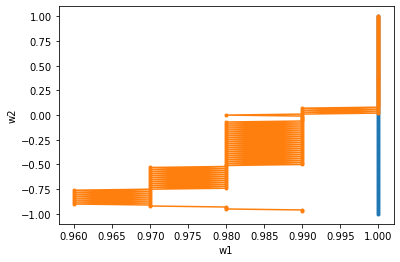

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

#training_weights = np.array(logger.weights).squeeze()
training_weights = np.array(training_weights).squeeze()
ax.plot(training_weights[..., 0], training_weights[..., 1], '.-')

In [15]:
model.get_weights()

[array([[ 0.99     ],
        [-0.9799987]], dtype=float32)]

In [16]:
weights[5]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.       , 0.8989899], dtype=float32)>

In [21]:
training_weights.shape[0] // NUM_SAMPLES

0

In [0]:
# Save data

with (DATA_DIR / "sem2_week5_stripe_target_weights.dat").open("w") as f:
    for w in weights.numpy():
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / "sem2_week5_stripe_training_weights.dat").open("w") as f:
    size = training_weights.shape[0]
    for w in training_weights:
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / "sem2_week5_stripe_target_outputs.dat").open("w") as f:
    for s in subgoals.numpy():
        s = s[1], s[3]
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / "sem2_week5_stripe_training_outputs.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions:
        s = s[1], s[3]
        f.write("\t".join(map(str, s)) + "\n")

In [23]:
loss_values = list(itertools.chain(*loss))

fig, ax = plt.subplots()
ax.plot(loss_values)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Loss")

NameError: ignored

In [24]:
predictions

array([[1.00000000e+00, 1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.00000000e+00, 1.32008466e-07, 1.83156393e-02, 1.98331550e-02],
       [1.00000000e+00, 1.54727459e-07, 1.83156393e-02, 2.14592349e-02],
       [1.00000000e+00, 1.81211576e-07, 1.83156393e-02, 2.32000668e-02],
       [1.00000000e+00, 2.12059120e-07, 1.83156393e-02, 2.50620581e-02],
       [1.00000000e+00, 2.47959349e-07, 1.83156393e-02, 2.70518363e-02],
       [1.00000000e+00, 2.89705639e-07, 1.83156393e-02, 2.91762426e-02],
       [1.00000000e+00, 3.38209247e-07, 1.83156393e-02, 3.14423218e-02],
       [1.00000000e+00, 3.94518139e-07, 1.83156393e-02, 3.38573046e-02],
       [1.00000000e+00, 4.59833444e-07, 1.83156393e-02, 3.64286192e-02],
       [1.00000000e+00, 5.35533957e-07, 1.83156393e-02, 3.91638651e-02],
       [1.00000000e+00, 6.23197934e-07, 1.83156393e-02, 4.20708284e-02],
       [1.00000000e+00, 7.24632059e-07, 1.83156393e-02, 4.51574177e-02],
       [1.00000000e+00, 8.41901908e-07, 1.83156393e

In [25]:
subgoals

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[1.00000000e+00, 1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.00000000e+00, 1.55223461e-07, 1.83156393e-02, 2.14932542e-02],
       [1.00000000e+00, 2.13407034e-07, 1.83156393e-02, 2.51399297e-02],
       [1.00000000e+00, 2.92442934e-07, 1.83156393e-02, 2.93094944e-02],
       [1.00000000e+00, 3.99445071e-07, 1.83156393e-02, 3.40592042e-02],
       [1.00000000e+00, 5.43817976e-07, 1.83156393e-02, 3.94495912e-02],
       [1.00000000e+00, 7.37960704e-07, 1.83156393e-02, 4.55441773e-02],
       [1.00000000e+00, 9.98146561e-07, 1.83156393e-02, 5.24089150e-02],
       [1.00000000e+00, 1.34566608e-06, 1.83156393e-02, 6.01117499e-02],
       [1.00000000e+00, 1.80827033e-06, 1.83156393e-02, 6.87219948e-02],
       [1.00000000e+00, 2.42197711e-06, 1.83156393e-02, 7.83094391e-02],
       [1.00000000e+00, 3.23340305e-06, 1.83156393e-02, 8.89435783e-02],
       [1.00000000e+00, 4.30260525e-06, 1.83156393e-02, 1.00692481e-01],
 

In [26]:
deviation_start = np.argwhere(training_weights[..., 0] != 1)[0, 0]
deviation_start

93

In [27]:
predictions[deviation_start:deviation_start+10]

array([[1.        , 0.01117132, 0.01983315, 0.98059046],
       [1.        , 0.01117132, 0.01831564, 0.9857029 ],
       [1.        , 0.01321496, 0.01983315, 0.99004954],
       [1.        , 0.01321496, 0.01831564, 0.9936202 ],
       [1.        , 0.01558251, 0.01983315, 0.9964063 ],
       [1.        , 0.01558251, 0.01831564, 0.99840117],
       [1.        , 0.01831554, 0.01983315, 0.99960005],
       [1.        , 0.02145913, 0.02145923, 1.        ],
       [1.        , 0.02145913, 0.01983315, 0.9996001 ],
       [1.        , 0.02319995, 0.01983315, 0.99840134]], dtype=float32)

In [28]:
predictions[-10:]

array([[1.        , 0.9747241 , 0.02506206, 0.04515783],
       [1.        , 0.9747241 , 0.02320007, 0.04207122],
       [1.        , 0.9857025 , 0.02506206, 0.03916424],
       [1.        , 0.9857025 , 0.02320007, 0.03642897],
       [1.        , 0.9900493 , 0.02320007, 0.03385764],
       [1.        , 0.9900493 , 0.02145923, 0.03144263],
       [1.        , 0.99362   , 0.02145923, 0.02917653],
       [1.        , 0.99640614, 0.02145923, 0.02705211],
       [1.        , 0.99640614, 0.01983315, 0.02506231],
       [1.        , 0.99840105, 0.01983315, 0.0232003 ]], dtype=float32)

In [29]:
subgoals[5]

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.000000e+00, 5.438180e-07, 1.831564e-02, 3.944959e-02],
      dtype=float32)>